In [3]:
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.9 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [108]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [109]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
input_size = 784
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.01

In [125]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Split train set into training (80%) and validation set (20%)
train_num = len(train_dataset)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]

# Verify lengths
len(train_idx), len(val_idx)


(48000, 12000)

In [126]:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [127]:
# Fully connected neural network
# NN1
class NeuralNet1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet1, self).__init__()
        self.fc1 = nn.Linear(input_size, 20) 
        self.fc2 = nn.Linear(20, 50) 
        self.fc3 = nn.Linear(in_features=50, out_features=20)
        self.fc4 = nn.Linear(in_features=20, out_features=10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return self.softmax(x)

# NN2
class NeuralNet2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.fc1 = nn.Linear(input_size, 10) 
        self.fc2 = nn.Linear(10, 20) 
        self.fc3 = nn.Linear(in_features=20, out_features=30)
        self.fc4 = nn.Linear(in_features=30, out_features=20)
        self.fc5 = nn.Linear(in_features=20, out_features=10)
        self.fc6 = nn.Linear(in_features=10, out_features=10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = nn.functional.relu(self.fc5(x))
        x = self.fc6(x)
        return self.softmax(x)

# NN3
class NeuralNet3(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet3, self).__init__()
        self.fc1 = nn.Linear(input_size, 10) 
        self.fc2 = nn.Linear(10, 40) 
        self.fc3 = nn.Linear(in_features=40, out_features=70)
        self.fc4 = nn.Linear(in_features=70, out_features=40)
        self.fc5 = nn.Linear(in_features=40, out_features=10)
        self.fc6 = nn.Linear(in_features=10, out_features=10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = nn.functional.relu(self.fc5(x))
        x = self.fc6(x)
        return self.softmax(x)
    
    
model1 = NeuralNet1(input_size, num_classes).to(device)
model2 = NeuralNet2(input_size, num_classes).to(device)
model3 = NeuralNet3(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [128]:
# Store losses for plotting later
train_losses = []
val_losses = []

# Train NN1
def train_model(model,criterion,optimizer,train_loader):
    total_val_time = 0
    start_train_time = time.time()
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0
        model.train()
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backprpagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Add training loss
            epoch_train_loss += loss.item()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                
        start_val_time = time.time()
        # Validation
        model.eval()
        with torch.no_grad():
            for images, labels in validation_loader:
                # move data to `device` where model resides
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)
                # forward pass for this batch
                outputs = model(images)
                # compute batch validation loss
                loss = criterion(outputs, labels)
                # keep track of loss incurred for each validation batch
                epoch_val_loss += loss.item()

            # compute training and validation loss incurred for this epoch
            epoch_train_loss = epoch_train_loss/len(train_loader)
            epoch_val_loss = epoch_val_loss/len(validation_loader)
            # store losses for each epoch for plotting later on
            train_losses.append(epoch_train_loss)
            val_losses.append(epoch_val_loss)
            total_val_time += (time.time()-start_val_time)

    total_training_time = time.time() - start_train_time
    print("Time take  to train (without taking account validation): {}".format(total_training_time-total_val_time))
                

# Test NN1
def test_model(model,test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Step [100/480], Train Loss: 1.7144
Epoch [1/20], Step [200/480], Train Loss: 1.6508
Epoch [1/20], Step [300/480], Train Loss: 1.6009
Epoch [1/20], Step [400/480], Train Loss: 1.6245
Epoch [2/20], Step [100/480], Train Loss: 1.7188
Epoch [2/20], Step [200/480], Train Loss: 1.6228
Epoch [2/20], Step [300/480], Train Loss: 1.7702
Epoch [2/20], Step [400/480], Train Loss: 1.6405
Epoch [3/20], Step [100/480], Train Loss: 1.6990
Epoch [3/20], Step [200/480], Train Loss: 1.6556
Epoch [3/20], Step [300/480], Train Loss: 1.6142
Epoch [3/20], Step [400/480], Train Loss: 1.6339
Epoch [4/20], Step [100/480], Train Loss: 1.6336
Epoch [4/20], Step [200/480], Train Loss: 1.6014
Epoch [4/20], Step [300/480], Train Loss: 1.6101
Epoch [4/20], Step [400/480], Train Loss: 1.6909
Epoch [5/20], Step [100/480], Train Loss: 1.7480
Epoch [5/20], Step [200/480], Train Loss: 1.6412
Epoch [5/20], Step [300/480], Train Loss: 1.5908
Epoch [5/20], Step [400/480], Train Loss: 1.6393
Epoch [6/20], Step [

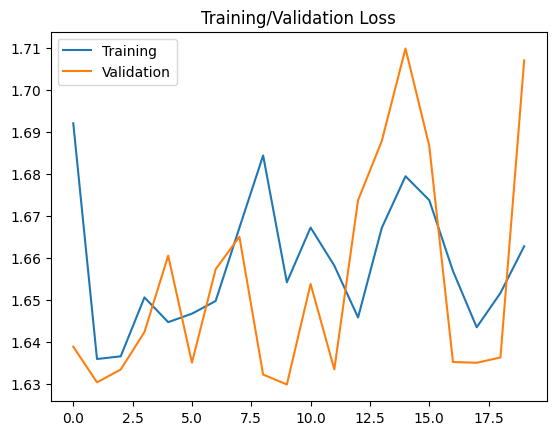

In [129]:
# Train NN1
train_model(model1,criterion,optimizer1,train_loader)

# Test NN1
test_model(model1,test_loader)

# Save the model checkpoint
# torch.save(model1.state_dict(), 'model1.ckpt')

# Plot losses
plt.title('Training/Validation Loss')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
print("Mean validation loss: {:4f}".format(sum(val_losses)/len(val_losses)))
plt.legend()
plt.show()

Epoch [1/20], Step [100/480], Train Loss: 1.8677
Epoch [1/20], Step [200/480], Train Loss: 1.7107
Epoch [1/20], Step [300/480], Train Loss: 1.9100
Epoch [1/20], Step [400/480], Train Loss: 1.8700
Epoch [2/20], Step [100/480], Train Loss: 1.7417
Epoch [2/20], Step [200/480], Train Loss: 1.7113
Epoch [2/20], Step [300/480], Train Loss: 1.7902
Epoch [2/20], Step [400/480], Train Loss: 1.8202
Epoch [3/20], Step [100/480], Train Loss: 1.7676
Epoch [3/20], Step [200/480], Train Loss: 1.8108
Epoch [3/20], Step [300/480], Train Loss: 1.8181
Epoch [3/20], Step [400/480], Train Loss: 1.8011
Epoch [4/20], Step [100/480], Train Loss: 1.7308
Epoch [4/20], Step [200/480], Train Loss: 1.8200
Epoch [4/20], Step [300/480], Train Loss: 1.8302
Epoch [4/20], Step [400/480], Train Loss: 1.8211
Epoch [5/20], Step [100/480], Train Loss: 2.0674
Epoch [5/20], Step [200/480], Train Loss: 2.0227
Epoch [5/20], Step [300/480], Train Loss: 2.0410
Epoch [5/20], Step [400/480], Train Loss: 2.0211
Epoch [6/20], Step [

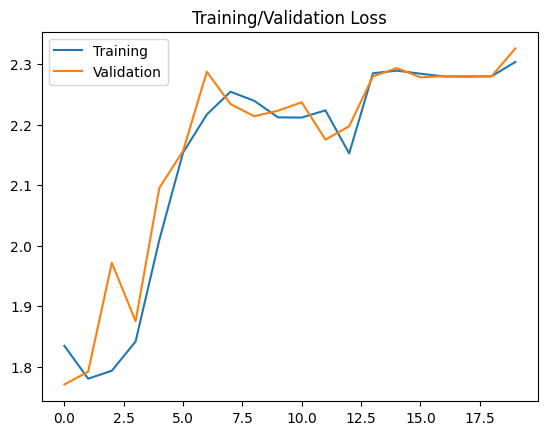

In [130]:
train_losses = []
val_losses = []
# Train NN2
train_model(model2,criterion,optimizer2,train_loader)

# Test NN2
test_model(model2,test_loader)

# Save the model checkpoint
#torch.save(model2.state_dict(), 'model2.ckpt')

# Plot losses
plt.title('Training/Validation Loss')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
print("Mean validation loss: {:4f}".format(sum(val_losses)/len(val_losses)))
plt.legend()
plt.show()

Epoch [1/20], Step [100/480], Train Loss: 1.9300
Epoch [1/20], Step [200/480], Train Loss: 1.7338
Epoch [1/20], Step [300/480], Train Loss: 1.8344
Epoch [1/20], Step [400/480], Train Loss: 1.8424
Epoch [2/20], Step [100/480], Train Loss: 1.7318
Epoch [2/20], Step [200/480], Train Loss: 1.7707
Epoch [2/20], Step [300/480], Train Loss: 1.8210
Epoch [2/20], Step [400/480], Train Loss: 1.9609
Epoch [3/20], Step [100/480], Train Loss: 2.0112
Epoch [3/20], Step [200/480], Train Loss: 1.9730
Epoch [3/20], Step [300/480], Train Loss: 1.8509
Epoch [3/20], Step [400/480], Train Loss: 1.9112
Epoch [4/20], Step [100/480], Train Loss: 2.2012
Epoch [4/20], Step [200/480], Train Loss: 2.0912
Epoch [4/20], Step [300/480], Train Loss: 1.9212
Epoch [4/20], Step [400/480], Train Loss: 1.9311
Epoch [5/20], Step [100/480], Train Loss: 1.9711
Epoch [5/20], Step [200/480], Train Loss: 2.0111
Epoch [5/20], Step [300/480], Train Loss: 1.9512
Epoch [5/20], Step [400/480], Train Loss: 1.9712
Epoch [6/20], Step [

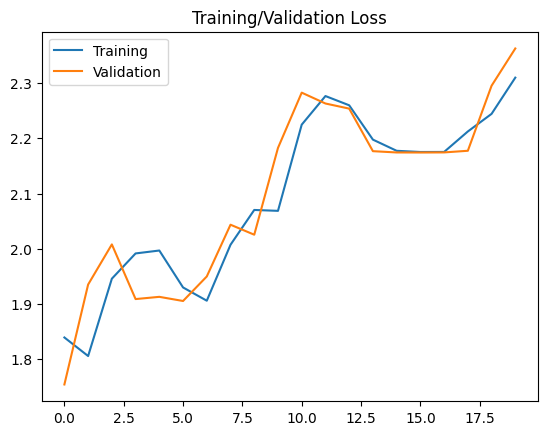

In [131]:
train_losses = []
val_losses = []
# Train NN3
train_model(model3,criterion,optimizer3,train_loader)

# Test NN3
test_model(model3,test_loader)

# Save the model checkpoint
# torch.save(model3.state_dict(), 'model3.ckpt')

# Plot losses
plt.title('Training/Validation Loss')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
print("Mean validation loss: {:4f}".format(sum(val_losses)/len(val_losses)))
plt.legend()
plt.show()

All of the three neural networks would take roughly the same amount of time to train. The three would fluctuate between 28 and 59 seconds depending on the session. Neural network 3 consistently obtained higher amount of validation loss, and obtained the least amount of testing accuracy. Neural network 1 consistently performed more accurate predictions on the testing dataset. Neural network 2's accuracy would fluctuate a lot more than 1's. So, in general, neural network 1 had the least amount of validation error.